# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

**Refer** https://docs.google.com/document/d/1uF8eOnVi4QrO3cDNYDd1OFeRmaW3PqNt8gjZWluS1IE/edit?usp=sharing for discussion

In [1]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score
from torchsummary import summary
from collections import Counter

In [2]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers   
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [3]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    # print(len(X_dna_seqs_train), len(X_dna_seqs_train[0]))
    
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X 
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2
    # use intseq_to_dnaseq here to convert ids back to DNA seqs
    temp = list(map(''.join, map(intseq_to_dnaseq, X_dna_seqs_train)))

    #step3
    # use count_cpgs here to generate labels with temp generated in step2
    y_dna_seqs = [count_cpgs(seq) for seq in temp]     
    return X_dna_seqs_train, y_dna_seqs
    
train_x, train_y = prepare_data(2048)
valid_x, valid_y = prepare_data(256)
test_x, test_y = prepare_data(512)

In [4]:
# Just a minor check to make sure it processed as expected
# train_x[0][:20], valid_x[0][:20], test_x[0][:20]

#### Optional EDA 

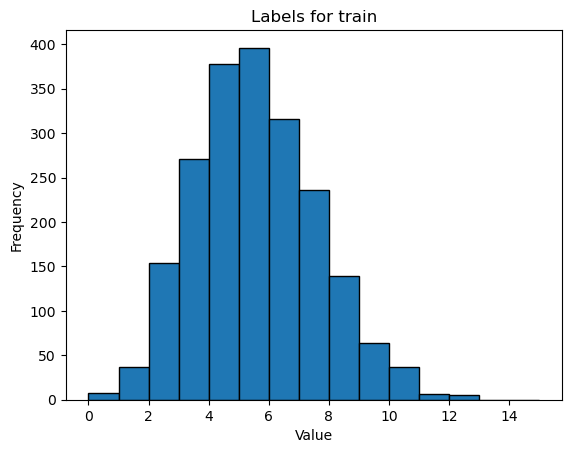

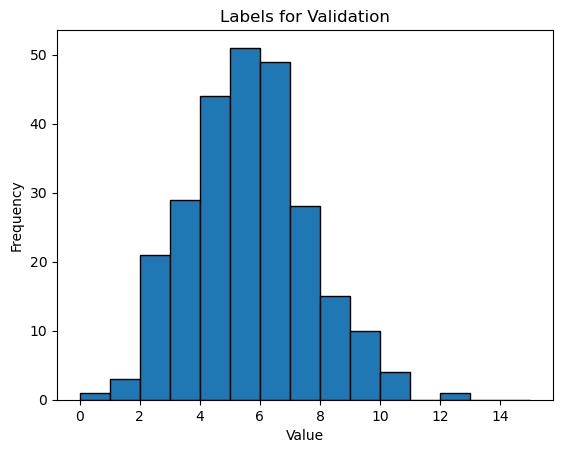

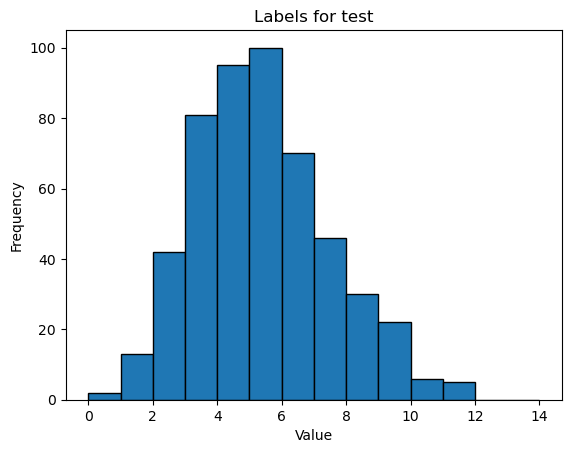

In [5]:
import matplotlib.pyplot as plt

def plot_hist(data, title):
    '''
    To plot histogram, to verify if there's a class imbalance 
    (incase we want to formulate it as a classification problem). 
    Always good to do some EDA as it won't hurt anyways whether we use or not!
    '''
    plt.hist(data, bins=range(min(data), max(data) + 4, 1), edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f"{title}")
    plt.show()

plot_hist(train_y, "Labels for train")
plot_hist(valid_y, "Labels for Validation")
plot_hist(test_y, "Labels for test")

In [6]:
# Statistics to know how many labels are there for each class
stats_train = Counter(train_y)
stats_valid = Counter(valid_y)
stats_test = Counter(test_y)
print(stats_train)
print("-"*10)
print(stats_valid)
print("-"*10)
print(stats_test)
print("-"*10)

Counter({5: 396, 4: 378, 6: 316, 3: 271, 7: 236, 2: 154, 8: 139, 9: 64, 10: 37, 1: 37, 0: 8, 11: 7, 12: 5})
----------
Counter({5: 51, 6: 49, 4: 44, 3: 29, 7: 28, 2: 21, 8: 15, 9: 10, 10: 4, 1: 3, 0: 1, 12: 1})
----------
Counter({5: 100, 4: 95, 3: 81, 6: 70, 7: 46, 2: 42, 8: 30, 9: 22, 1: 13, 10: 6, 11: 5, 0: 2})
----------


#### Work in progress thought - Reframing it as classification problem
Here we can clearly see there's class imbalance in all our train/valid and test datasets! While we shouldn't change anything in test dataset, for train and valid, we have to make sure that the model sees the minor classes as frequent as majority ones, because otherwise all it is learning is to predict the majority class which is 5

**Note:** This is valid if we are viewing the problem as classification. For regression, while the logic is still valid, using the term "classes" won't make sense!

In [7]:
# from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler

# example_weights = [class_weights[e['output']] for e in train_dataset]
# print(f"Example weights unique items are: {set(example_weights)}")

# sampler = WeightedRandomSampler(example_weights, train_size, replacement=True)

In [8]:
# some config
LSTM_INPUT_SIZE = 128
LSTM_HIDDEN = 256
LSTM_LAYER = 2
batch_size = 256
learning_rate = 0.001
weight_decay = 1e-5
epoch_num = 500
device = 'cuda:0'

In [9]:
# Converting the data to proper tensor formats!
# TODO/NOTE: (minor) dtype can be reduced as float32 might be an overkill for this problem.

train_x_pt = torch.tensor(train_x, dtype=torch.float32)
train_y_pt = torch.tensor(train_y, dtype=torch.float32)

valid_x_pt = torch.tensor(valid_x, dtype=torch.float32)
valid_y_pt = torch.tensor(valid_y, dtype=torch.float32)

test_x_pt = torch.tensor(test_x, dtype=torch.float32)
test_y_pt = torch.tensor(test_y, dtype=torch.float32)

In [10]:
# create data loader

train_data_loader = DataLoader(list(zip(train_x_pt,train_y_pt)), batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(list(zip(valid_x_pt,valid_y_pt)), batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(list(zip(test_x_pt,test_y_pt)), batch_size=batch_size)

In [11]:
# VALIDATION CHECK
# Having a small (and same) train and validation data should get 0 train and validation loss
# i.e overfitting. This makes sure that the model is learning something!
# Answer: In my case, it did overfitted (as expected) as the loss went to 0, 
# so there's no visible bug in code as the model is learning!

# mini_data_loader = DataLoader(list(zip(train_x_pt[:10],train_y_pt[:10])),shuffle=False)
# train_data_loader, valid_data_loader, test_data_loader = mini_data_loader, mini_data_loader, mini_data_loader

In [12]:
# Model
class CpGPredictor(torch.nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self):
        super(CpGPredictor, self).__init__()
        # TODO complete model, you are free to add whatever layers you need here
        # We do need a lstm and a classifier layer here but you are free to implement them in your way
        self.lstm = nn.LSTM(LSTM_INPUT_SIZE, LSTM_HIDDEN, LSTM_LAYER, batch_first=True,
                            dropout=0.2, bidirectional=True)

        self.dropout = nn.Dropout(0.2)
        # Have a hidden layer to map non-linearities!
        # NOTE: If it's BiLSTM -> Need to have *2 !! 
        self.hidden1 = nn.Linear(LSTM_HIDDEN*2, LSTM_HIDDEN//2)

        self.relu = nn.ReLU()

        self.hidden2 = nn.Linear(LSTM_HIDDEN//2, LSTM_HIDDEN//4)

        # Final classification layer
        self.classifier = nn.Linear(LSTM_HIDDEN//4, 1)

    def forward(self, x):
        # TODO complete forward function
        # Standard network
        # x -> lstm -> dense1 -> relu -> dropout -> dense2 -> relu -> dropout -> classifier -> output
        lstm_out, _ = self.lstm(x)
        # print(lstm_out.shape) # batch_size x LSTM_HIDDEN
        # This might not make sense as our tensor is 2D for eg: (32, 128)
        # TODO: Can we make it to 3D tensor and model! Think more on pros and cons! 
        # last_output = lstm_out[:, -1, :]
        output = lstm_out

        output = self.hidden1(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.hidden2(output)
        output = self.relu(output)
        output = self.dropout(output)
        
        logits = self.classifier(output)
        # print(logits.shape) # batch_size x 1
        # print(logits)
        return logits.squeeze(1) # removing 1

In [13]:
# init model / loss function / optimizer etc.
model = CpGPredictor()
model.to(device)

loss_fn = {}

# MSE is not reducing the validation loss
loss_fn['mse'] = nn.MSELoss()

# Multiclass targets, can use cross entropy loss
loss_fn['ce'] = nn.CrossEntropyLoss()

# The data distribution follows Poisson, so might be this is a better choice
loss_fn['poisson'] = nn.PoissonNLLLoss()

# Actually, it looks more like Gaussian!
loss_fn['gaussian'] = nn.GaussianNLLLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

/hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# summary(model.to('cuda'), (1, 128))

# for name, params in model.named_parameters():
#     print(name, params.shape)

# sum([param.nelement() for param in model.parameters()])

In [15]:
# A quick check!

# train_x_pt[0:2].shape
# logits = model(train_x_pt[0:2])
# print(logits.shape)
# print(logits)

In [16]:
def compute_metrics(res_gt, res_pred):
    # For regression, reporting r2 score!
    r2score = r2_score(res_gt, res_pred)

    # NOTE: Defining accuracy in a crude sense that the raw prediction has to be rounded up/down
    res_pred_rounded = [float(round(res)) for res in res_pred]
    accuracy = accuracy_score(res_gt, res_pred_rounded)

    # NOTE: Precision and recall won't make sense for regression problem!
    # Don't use them for any analysis unless we convert it to classification problem!
    
    # precision = precision_score(res_gt, res_pred_rounded, average='macro', zero_division=0)
    # recall = recall_score(res_gt, res_pred_rounded, average='macro', zero_division=0)

    # return r2score, accuracy, precision, recall
    return r2score, accuracy

In [17]:
# Don't pick the best model based on accuracy, as we are not optimizing on that! Use that for analysis
def train():
    # training (you can modify the code below)
    t_loss = 0
    v_loss = 0
    t_loss_list = []
    v_loss_list = []

    y_pred_list = []
    y_true_list = []

    train_acc_list = []
    valid_acc_list = []

    train_r2_list = []
    valid_r2_list = []

    best_v_loss = 0
    best_model_state_dict = model.state_dict()

    for epoch in range(epoch_num):
        for batch in train_data_loader:
            model.zero_grad()
            model.train()
            #TODO complete training loop
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(inputs.shape)

            # If using Gaussian loss, should have variance (assuming homoscedastic condition)
            # labels_unsq = labels.unsqueeze(1)
            # var = torch.ones(labels_unsq.shape[0], labels_unsq.shape[1], 
            #                     requires_grad=True, device=device)

            y_pred = model(inputs)
            loss_mse = loss_fn['mse'](y_pred, labels)

            y_pred_list.extend(y_pred.tolist())
            y_true_list.extend(labels.tolist())

            # print(y_pred.shape, labels_unsq.shape, var.shape)
            ## If Gaussian, loss will have variance term!
            # y_pred_unsq = y_pred.unsqueeze(1)
            # # print(y_pred_unsq.device, labels_unsq.device, var.device)
            # loss_gau = loss_fn['gaussian'](y_pred_unsq, labels_unsq, var)
            # print(loss_mse, loss_gau)
            # loss = loss_mse + loss_gau

            # loss_ce = loss_fn['ce'](y_pred, labels)
            # loss = loss_mse + loss_ce

            loss = loss_mse
            t_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_r2, train_acc = compute_metrics(y_true_list, y_pred_list)
        train_acc_list.append(train_acc)
        train_r2_list.append(train_r2)

        y_pred_list = []
        y_true_list = []

        model.eval()
        with torch.no_grad():
            for batch in valid_data_loader:
                inputs, labels = batch

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                predictions = model(inputs)
                loss_mse = loss_fn['mse'](predictions, labels)

                y_pred_list.extend(predictions.tolist())
                y_true_list.extend(labels.tolist())
            
                # If using Gaussian NLL, need to postprocess the shapes a bit
                # labels_unsq = labels.unsqueeze(1)
                # var = torch.ones(labels_unsq.shape[0], labels_unsq.shape[1], 
                #                 requires_grad=True, device=device)
                # predictions_unsq = predictions.unsqueeze(1)
                # loss_gau = loss_fn['gaussian'](predictions_unsq, labels_unsq, var)

                # loss = loss_mse + loss_gau
                # loss = loss_mse

                # loss_ce = loss_fn['ce'](y_pred, labels)
                # loss = loss_mse + loss_ce

                loss = loss_mse

                v_loss += loss.item()

            if best_v_loss == 0 or v_loss < best_v_loss:
                print(f"Best model found at epoch {epoch} with validation loss {best_v_loss}")
                best_model_state_dict = copy.deepcopy(model.state_dict())
                best_v_loss = v_loss
        
        valid_r2, valid_acc = compute_metrics(y_true_list, y_pred_list)
        valid_acc_list.append(valid_acc)
        valid_r2_list.append(valid_r2)
        
        t_loss_list.append(t_loss)
        v_loss_list.append(v_loss)
        # print(f"Epoch {epoch}: Training Loss = {t_loss}, Validation Loss = {v_loss}")
        y_pred_list = []
        y_true_list = []

        t_loss = 0
        v_loss = 0
    return (best_model_state_dict, t_loss_list, v_loss_list, train_acc_list, 
            valid_acc_list, train_r2_list, valid_r2_list)

In [41]:
def plot_metrics(train_loss, val_loss, label1='Training Loss', label2='Validation Loss'):
    
    epochs = range(1, len(train_loss) + 1)

    # Initial loss values are too high, so avoiding them in plot for easier viz!
    plt.plot(epochs[10:], train_loss[10:], label=label1, marker='o')
    plt.plot(epochs[10:], val_loss[10:], label=label2, marker='*')

    metric = label1.split(' ')[-1]
    plt.xlabel('Epochs')
    plt.ylabel(f'{metric}')
    plt.title(f'Training and Validation {metric}')
    plt.legend()

    plt.grid(True)
    plt.show()

In [19]:
(best_model_state_dict, t_loss_list, v_loss_list, train_acc_list, 
                        valid_acc_list, train_r2_list, valid_r2_list) = train()

Best model found at epoch 0 with validation loss 0
Best model found at epoch 2 with validation loss 4.591680526733398
Best model found at epoch 3 with validation loss 4.08831262588501
Best model found at epoch 19 with validation loss 3.980140209197998


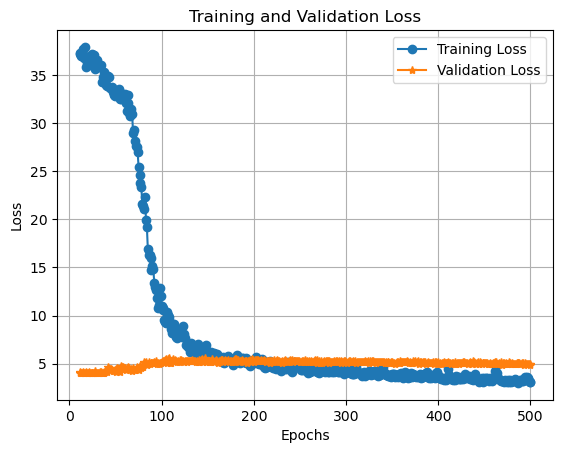

In [42]:
plot_metrics(t_loss_list, v_loss_list)

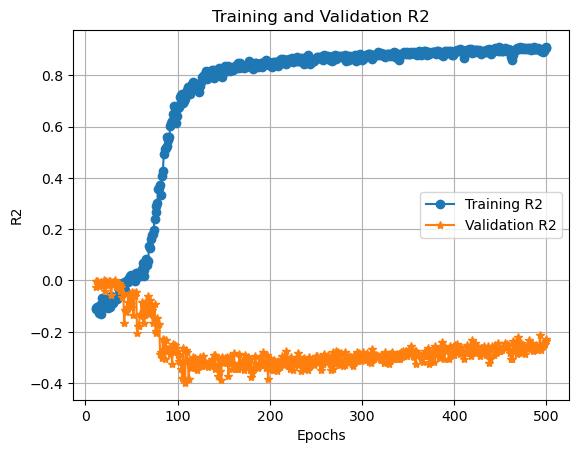

In [43]:
# Training and validation r2 score, more r2 means better regression
plot_metrics(train_r2_list, valid_r2_list, "Training R2", "Validation R2")

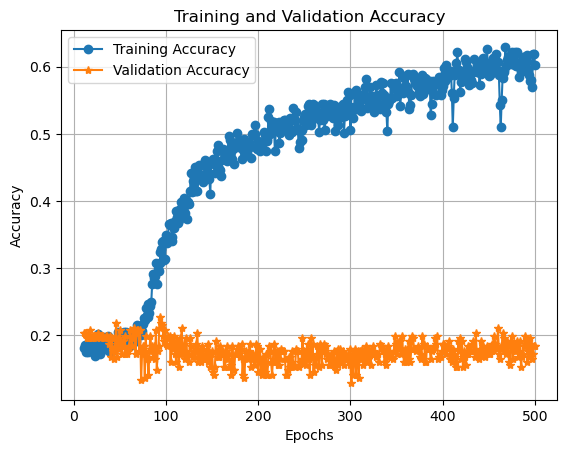

In [44]:
# Training and validation accuracy, to verify the model is learning something
plot_metrics(train_acc_list, valid_acc_list, "Training Accuracy", "Validation Accuracy")

In [23]:
# Copy the best model state dict for testing purpose!
best_model = CpGPredictor()
best_model.load_state_dict(best_model_state_dict)
best_model.to(device)

CpGPredictor(
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden1): Linear(in_features=512, out_features=128, bias=True)
  (relu): ReLU()
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

In [24]:
def evaluate_model(model):
    # eval (you can modify the code below)
    model.eval()

    res_gt = []
    res_pred = []

    test_loss = 0
    for batch in test_data_loader:
        # TODO complete inference loop
        inputs, labels = batch

        inputs = inputs.to(device)
        labels = labels.to(device)

        y_pred = model(inputs)

        res_gt.extend(labels.tolist())
        res_pred.extend(y_pred.tolist())

        loss_mse = loss_fn['mse'](y_pred, labels)
        

        # Extra lines of code for Gaussian
        # labels_unsq = labels.unsqueeze(1)
        # var = torch.ones(labels_unsq.shape[0], labels_unsq.shape[1], requires_grad=True)
        # y_pred_unsq = y_pred.unsqueeze(1)
        # loss_gau = loss_fn['gaussian'](y_pred_unsq, labels_unsq, var)

        # loss = loss_mse + loss_gau

        # loss_ce = loss_fn['ce'](y_pred, labels)
        # loss = loss_mse + loss_ce

        loss = loss_mse
        test_loss += loss.item()

    return test_loss, res_gt, res_pred

In [25]:
best_model_test_loss, best_model_res_gt, best_model_res_pred = evaluate_model(best_model)

In [26]:
# best_acc , best_pre, best_rec = compute_metrics(best_model_res_gt, best_model_res_pred)
# best_model_test_loss, best_acc, best_pre, best_rec

best_r2, best_acc = compute_metrics(best_model_res_gt, best_model_res_pred)
print(f"Best model loss, R2 and acc is: {best_model_test_loss}, {best_r2}, {best_acc}")

Best model loss, R2 and acc is: 8.901482105255127, -0.009629586554385616, 0.197265625


Preliminary conclusion - Everything is mostly getting predicted as 5! that's why the final accuracy is 20% 

So, the model learned to predict the mean of distribution!

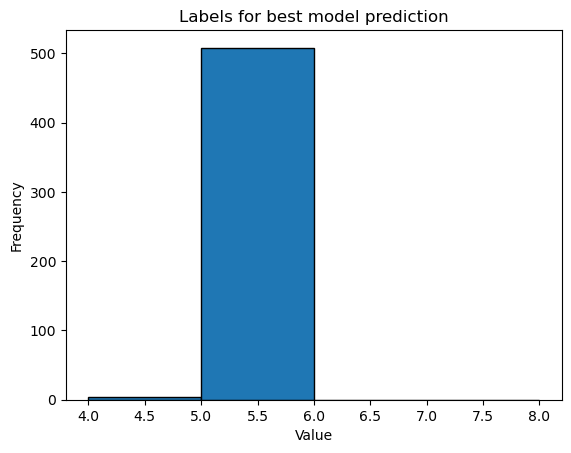

In [27]:
import math
best_res_pred_rounded = [int(round(res)) for res in best_model_res_pred]
plot_hist(best_res_pred_rounded, "Labels for best model prediction")

In [28]:
torch.save(best_model.state_dict(), "trial_model_part1.pkl")

# Part 2: what if the DNA sequences are not the same length

In [29]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [30]:
# DO NOT CHANGE HERE
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers   
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [31]:
# TODO complete the task based on the change
def pad_sequence(sequence: Sequence[int], max_len: int) -> Sequence[int]:
    padded_sequence = sequence[:max_len] + [0] * (max_len - len(sequence))
    return padded_sequence

def prepare_data(num_samples=100, min_len=16, max_len=128):
    # TODO prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    #step 1
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))
    #step 2. Pad all the examples with max length!
    X_dna_seqs_train_padded = [pad_sequence(seq, max_len) for seq in X_dna_seqs_train]
    
    temp = list(map(''.join, map(intseq_to_dnaseq, X_dna_seqs_train_padded)))
    #step3
    y_dna_seqs = [count_cpgs(seq) for seq in temp]
    
    return X_dna_seqs_train, y_dna_seqs

    
min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
valid_x, valid_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

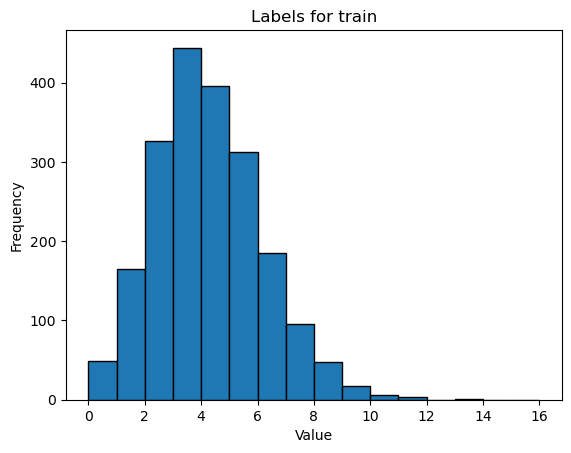

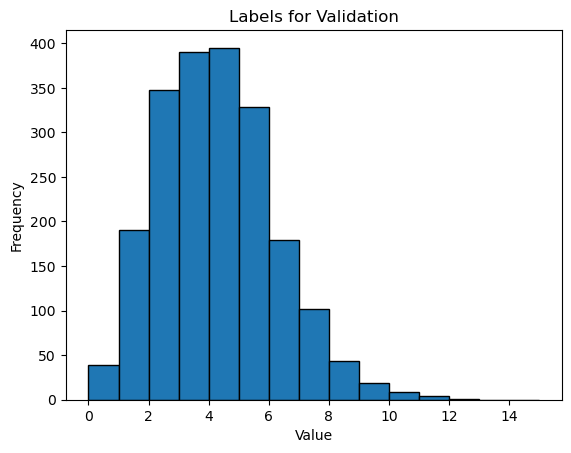

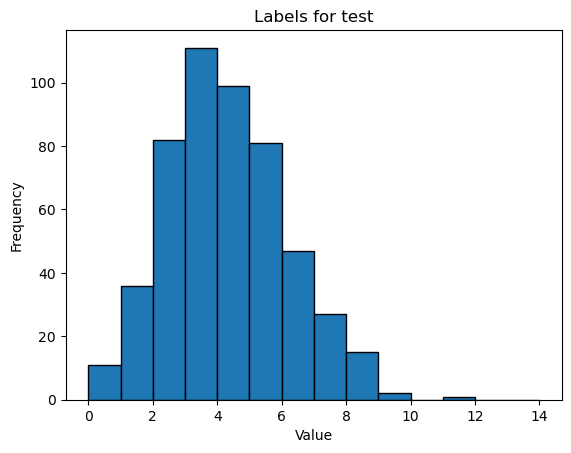

In [32]:
plot_hist(train_y, "Labels for train")
plot_hist(valid_y, "Labels for Validation")
plot_hist(test_y, "Labels for test")

In [33]:
# Quick check to confirm the changes i.e different examples should have different lengths!
# train_x[:1], train_y[:1]
eg = list(map(''.join, map(intseq_to_dnaseq, train_x[:10])))
eg0, eg1 = eg[0], eg[1]
print(len(eg0), len(eg1))

97 107


In [34]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels) -> None:
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        return torch.LongTensor(self.lists[index]), self.labels[index]

    def __len__(self):
        return len(self.lists)

    
# this will be a collate_fn for dataloader to pad sequence  
class PadSequence:
    #TODO
    def __init__(self, padding_value=0):
        self.padding_value = padding_value
    
    def __call__(self, batch):
        # Sort the batch by sequence length
        batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
        # Separate sequences and labels
        sequences, labels = zip(*batch)
        # Pad sequences
        # 1. either use the max of batch length 
        # 2. Or a constant for eg: 128. 
        # Using the max-batch will result in batches with different lengths i.e [32, 108], [32, 126] etc; 
        # max_length = max(len(seq) for seq in sequences)

        max_length = 128
        # Tried using pad_sequence but it throws an unexpected error. 
        # Can use the other functions but for timebeing, this serves the purpose 
        padded_sequences = []
        for seq in sequences:
            pad_length = max_length - len(seq)
            # print(pad_length)
            pad_tensor = torch.full((pad_length,), self.padding_value, dtype=torch.long)
            # print(pad_tensor)
            padded_seq = torch.cat((seq, pad_tensor), dim=0)
            # padded_seq = seq + [self.padding_value] * pad_length
            padded_sequences.append(padded_seq)
        # Convert to tensor
        padded_sequences = torch.stack(padded_sequences, dim=0)
        labels_tensor = torch.tensor(labels, dtype=torch.long)
        return padded_sequences, labels_tensor

In [35]:
# TODO complete the rest
train_dataset = MyDataset(train_x, train_y)
valid_dataset = MyDataset(valid_x, valid_y)
test_dataset = MyDataset(test_x, test_y)

In [36]:
batch_size = 32

In [37]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=PadSequence())
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=PadSequence())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=PadSequence())

In [45]:
# init model / loss function / optimizer etc.
model = CpGPredictor()
model.to(device)

loss_fn = {}

loss_fn['mse'] = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
(best_model_state_dict, t_loss_list, v_loss_list, train_acc_list, 
                        valid_acc_list, train_r2_list, valid_r2_list) = train()

Best model found at epoch 0 with validation loss 0
Best model found at epoch 1 with validation loss 4.5790863037109375


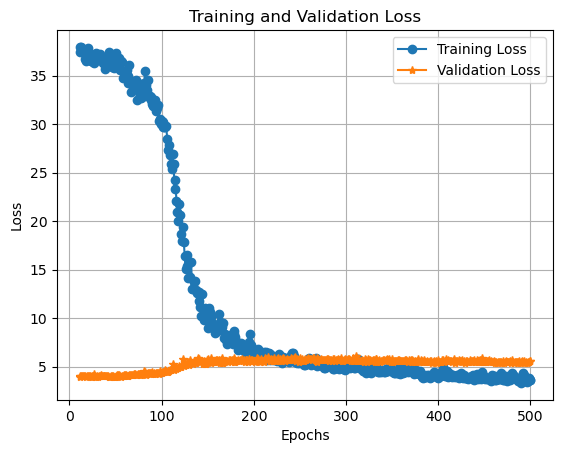

In [47]:
plot_metrics(t_loss_list, v_loss_list)

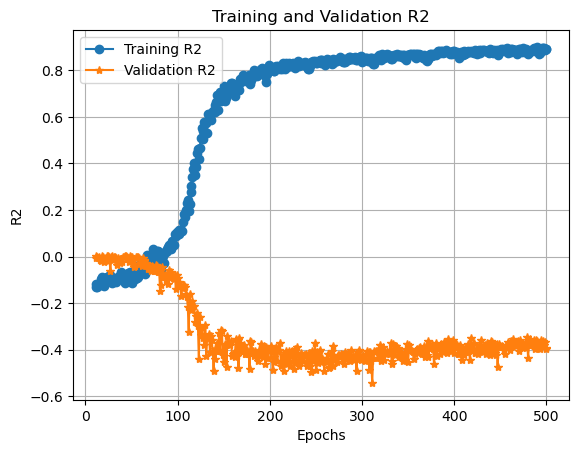

In [48]:
# Training and validation r2 score, more r2 means better regression
plot_metrics(train_r2_list, valid_r2_list, "Training R2", "Validation R2")

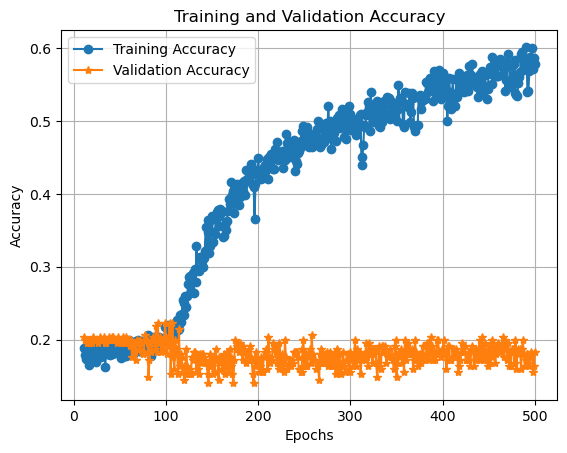

In [49]:
# Training and validation accuracy, to verify the model is learning something
plot_metrics(train_acc_list, valid_acc_list, "Training Accuracy", "Validation Accuracy")

In [50]:
best_model = CpGPredictor()
best_model.load_state_dict(best_model_state_dict)
best_model.to(device)

CpGPredictor(
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden1): Linear(in_features=512, out_features=128, bias=True)
  (relu): ReLU()
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

In [51]:
best_model_test_loss, best_model_res_gt, best_model_res_pred = evaluate_model(best_model)
best_r2, best_acc = compute_metrics(best_model_res_gt, best_model_res_pred)
print(f"Best model loss, R2 and acc is: {best_model_test_loss}, {best_r2}, {best_acc}")

Best model loss, R2 and acc is: 8.940806865692139, -0.01408990831117718, 0.197265625


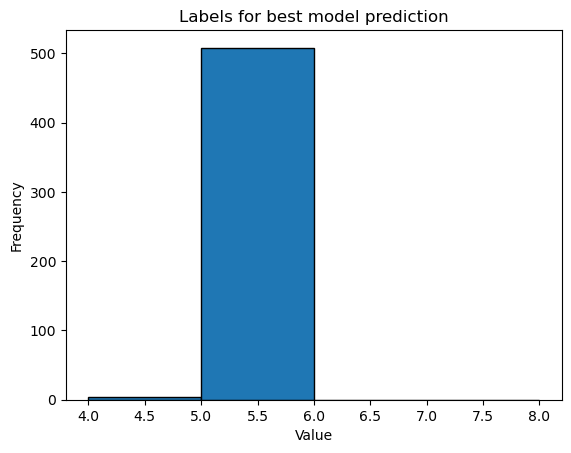

In [52]:
import math
best_res_pred_rounded = [int(round(res)) for res in best_model_res_pred]
plot_hist(best_res_pred_rounded, "Labels for best model prediction")

In [53]:
torch.save(best_model.state_dict(), "trial_model_part2.pkl")